In [1]:
### Setup the RADAR parameters

In [2]:
fc = 4e3            # Carrier Frequency, Center Frequency
vp = 343            # Phase Velocity of sound
T  = 1/fc           # period of one Carrier Frequency
Lambda = vp/fc

# Setup Time portion
PRI = 0.25         # Pulse Repetition Interval (seconds)
PRF = 1/PRI         # Pulses per second (hertz)

#Num cycles per pulse packet
k = 5             # k cycles of fc in the pulse packet
PW = k*T            # k cycles * Period of fc
BW = 1/PW           # Bandwidth of the RADAR Pulse

# error check
if PW >= PRI:
    print('Error: Pulse width much too long -- PRI: {}, PW = {}'.format(PRI, PW))

print('='*20)
print("Time and Frequency")
print('PRI:{} s, PW {}s, Fc {} Hz, Tc {} s'.format(PRI, PW, fc, T))
print('\n')
    
# Spatial information
R_unamb = (PRI*vp)/2 # Unambiguous Range
PRI_x = PRI * vp
PW_x = PW * vp
kc = fc/vp

print('='*20)
print("Space and Time")
print('PRI:{:.02f} m, PW {:.02f} m, kc {:.02f} cycles/meter, lambda {:.02f} m'
      .format(PRI_x, PW_x, kc, Lambda))


Time and Frequency
PRI:0.25 s, PW 0.00125s, Fc 4000.0 Hz, Tc 0.00025 s


Space and Time
PRI:85.75 m, PW 0.43 m, kc 11.66 cycles/meter, lambda 0.09 m


In [3]:
import pyaudio
import wave
import sys
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
import pylab

# recording configs
CHUNK = 2048
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 96000
RECORD_SECONDS = 4
NFRAMES = int((RATE / CHUNK) * RECORD_SECONDS)
NSAMPS = NFRAMES * CHUNK
print(NSAMPS)
WAVE_OUTPUT_FILENAME = "output.wav"

# create & configure microphone
mic = pyaudio.PyAudio()
stream = mic.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

# read & store microphone data per frame read
frames = []
trigger = 0
sleep(0.01)
print("* Awaiting Trigger *")
while trigger < 20000:
    dataTrig = stream.read(CHUNK)
    decoded = np.frombuffer(dataTrig,dtype=np.int16);
    trigger = np.amax(decoded)
    #display(trigger)
    sleep(0.001)

print("* recording *")

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    numpydata = np.frombuffer(data,dtype=np.int16)
    frames.append(data)

print("* done recording *")

# kill the mic and recording
stream.stop_stream()
stream.close()
mic.terminate()


382976
* Awaiting Trigger *
* recording *
* done recording *


In [4]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [5]:
#combine & store all microphone data to output.wav file
outputFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
outputFile.setnchannels(CHANNELS)
outputFile.setsampwidth(mic.get_sample_size(FORMAT))
outputFile.setframerate(RATE)
outputFile.writeframes(b''.join(frames))
outputFile.close()

# Plot
time = np.arange(0, float(numpydata.shape[0]), 1) / RATE
#plt.plot(time, numpydata)

# SciPy Import
import scipy.io.wavfile
rate,audData=scipy.io.wavfile.read('output.wav')

#wav bit type the amount of information recorded in each bit often 8, 16 or 32 bit
audData.dtype

print("Data Shape:")
print(np.shape(audData))

#wav length
len_PRI = audData.shape[0] / rate

#wav number of channels mono/stereo 
audData.shape[1]

#if stereo grab both channels
channel1=audData[:,0] #left 
# channel2=audData[:,1] #right

channelX = audData[:X] # Channel # = X

# Quick bandpass filter to clean up noise.
channel1 = butter_bandpass_filter(channel1, 2.5e3, 5.5e3, fs=96000, order=1)

96000
[[ 602  626]
 [ 965  976]
 [1242 1247]
 ...
 [ 499  343]
 [ 849  537]
 [1192  718]]
Data Shape:
(382976, 2)


80000
[    0.         31855.62760586 29148.73274129 ...     0.
     0.             0.        ]
Data Shape:
(20000,)


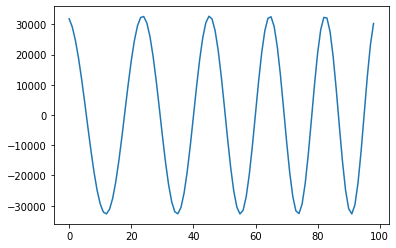

In [6]:
# Cross Correlation Kernel
# Plot
time = np.arange(0, float(numpydata.shape[0]), 1) / RATE
#plt.plot(time, numpydata)

# SciPy Import
kernelRate,kernelAudData=scipy.io.wavfile.read('Kernel_PulseTrain_chirp_4000_025_005.wav')

#the sample rate is the number of bits of infomration recorded per second
print(kernelRate)
print(kernelAudData)

#wav bit type the amount of information recorded in each bit often 8, 16 or 32 bit
kernelAudData.dtype

print("Data Shape:")
print(np.shape(kernelAudData))

#wav length
kernel_len_PRI = kernelAudData.shape[0] / rate

#Final kernel
kernel = np.trim_zeros(kernelAudData,'fb')
plt.plot(kernel)

In [7]:
# Padding
print('Channel 1 Length:'), print (len(channel1))
print('NSAMPS Length:'), print (NSAMPS)

while np.mod(NSAMPS,RECORD_SECONDS) != 0:
    NSAMPS += 1
    print(NSAMPS)

if len(channel1) > NSAMPS:
    mod_channel1 = channel1[NSAMPS - len(channel1)]
    print("* Shortened *")
    print('NEW Channel 1 Length:'), print (len(mod_channel1))
if len(channel1) < NSAMPS:
    mod_channel1 = np.pad(channel1, (0,NSAMPS-len(channel1)), 'median')
    print("* Padded *")
    print('NEW Channel 1 Length:'), print (len(mod_channel1))
if len(channel1) == NSAMPS:
    mod_channel1 = channel1


# N Observations Effect
# provide n observation effects
channel1_env = mod_channel1.reshape(RECORD_SECONDS, int(NSAMPS/RECORD_SECONDS))
# add them all together
n_obs_channel1_env = channel1_env.sum(axis=0)

print('Summed Length:'),print(len(n_obs_channel1_env))

# Turn off Shaping
#n_obs_channel1_env = channel1

Channel 1 Length:
382976
NSAMPS Length:
382976
Summed Length:
95744


(None, None)

Original array length: 4787
New array length: 4885


<StemContainer object of 3 artists>

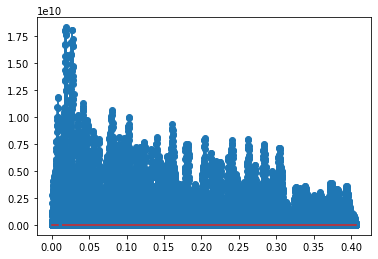

In [9]:
# Cross Correlation:
from scipy.signal import correlate

PRI_index = int(len(n_obs_channel1_env)/CHANNELS)
zoom = 10
PRI_index_zoom = int(PRI_index/zoom)

xcorr_array = np.absolute(correlate(n_obs_channel1_env[0:PRI_index_zoom],kernel,'full'))
xcorr_Len = len(xcorr_array)
print('Original array length: {}'.format(len(n_obs_channel1_env[0:PRI_index_zoom])))
print('New array length: {}'.format(xcorr_Len))

time3 = np.arange(0, xcorr_Len, 1) / rate*RECORD_SECONDS*CHANNELS
time4 = np.arange(0, len(kernel), 1) / rate*RECORD_SECONDS*CHANNELS

plt.stem(time3,xcorr_array,use_line_collection=True)
plt.stem(time3,n_obs_channel1_env[0:xcorr_Len],use_line_collection=True)
plt.stem(time4,-1*kernel,use_line_collection=True)

In [47]:
# Target Detection
# Find Peaks still used as threshold function was built later

from scipy.signal import find_peaks
R_unamb_zoom = R_unamb
scalar = np.median(np.absolute(xcorr_array[0:int(len(xcorr_array)/10)]))*2.2
peaks, _ = find_peaks(xcorr_array, height=scalar, distance=60)

# make the distance vector
nsamps = int(len(xcorr_array))
x = np.linspace(0,R_unamb_zoom, nsamps)
dx = R_unamb_zoom/nsamps

# Pandas Table
import pandas as pd
# intialise data of lists.
data = {'Distance':peaks*dx,
        'Return Strength':xcorr_array[peaks]}
 
# Create DataFrame
df = pd.DataFrame(data)
df = df.style.set_properties(**{
    'font-size': '10pt'})
    
# Print the output.
display(df)
print('Total Targets: {}' .format(len(peaks)))

,Distance,Return Strength
0,0.807472,1.18169e+10
1,2.0099,1.82807e+10
2,2.84371,1.80694e+10
3,3.71262,1.01325e+10
4,4.35333,1.12515e+10
5,8.45212,1.06477e+10
6,10.8131,9.96702e+09


Total Targets: 7


Text(0, 0.5, 'Relative Power')

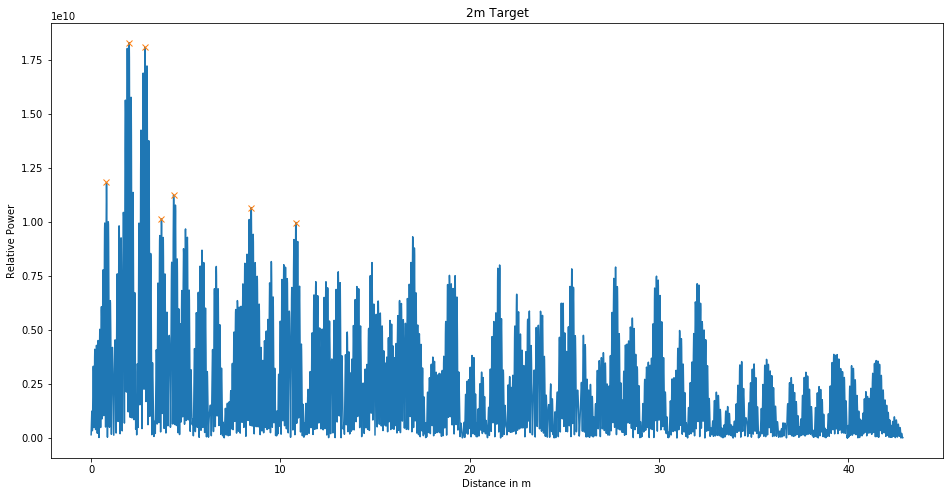

In [48]:
# Distance Plot

plt.figure(figsize=(16,8))
plt.plot(x,xcorr_array[0:nsamps])
plt.plot(peaks*dx,xcorr_array[peaks], 'x')
plt.title('2m Target')
plt.xlabel('Distance in m')
plt.ylabel('Relative Power')

In [46]:
#### Time PLOT (Useful for debugging)
'''
time = np.arange(0, float(audData.shape[0]), 1) / rate 
time2 = np.arange(0, PRI_index_zoom, 1) / rate*RECORD_SECONDS*CHANNELS


# Test Prints
#print(np.shape(n_obs_channel1_env))
#print(len(n_obs_channel1_env[0:PRI]))
#print(len(time2))
#print(len(channel1))
#print(len(time))

#plot amplitude (or loudness) over time
plt.clf()
plt.figure(figsize=(16,8))
#channel1fig = plt.semilogy(time, channel1, linewidth=0.1, alpha=0.6, color='#0000FF', label="Channel 1")
NObsReshape = plt.plot(time2, np.absolute(n_obs_channel1_env[0:PRI_index_zoom]), linewidth=0.2, alpha=1.0, color='#FF0000', label="NObs Reshape")

plt.title('Returns in Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# defining legend style and data
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Channel 1')
reds_line = mlines.Line2D([], [], color='red', label='NObs Reshape')

plt.legend(handles=[blue_line, reds_line],loc='upper right')

np.savetxt("RadarData.csv", np.absolute(n_obs_channel1_env[0:PRI_index_zoom]), delimiter=",")

'''
print("Have a nice Day")

Have a nice Day
